# Brain Tumor Detection
Description
This dataset was originally created by Yousef Ghanem. To see the current project, which may have been updated since this version, please go here: https://universe.roboflow.com/yousef-ghanem-jzj4y/brain-tumor-detection-fpf1f.

This dataset is part of RF100, an Intel-sponsored initiative to create a new object detection benchmark for model generalizability.

Access the RF100 Github repo: https://github.com/roboflow-ai/roboflow-100-benchmark

## Imports

In [11]:
from tqdm.notebook import tqdm

from dotenv import load_dotenv
load_dotenv()

import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
tf.config.list_physical_devices('GPU'), tf.__version__

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.18.0')

In [12]:
# auto reload dotenv 
%load_ext dotenv
%dotenv

# auto reload libs
%load_ext autoreload
%autoreload 2

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from utils.visualization_funcs import plot_random_images_bbox
from utils.prepare_dataset import PrepareDataset

## Paths Setup

In [14]:
from hydra import initialize, compose

# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.TRAIN_DIR)

datasets/brain-tumor-2/train/


In [15]:
cfg.DATASET_DIRS

{'TRAIN_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/train/', 'VALIDATION_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/valid', 'TEST_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/test'}

In [16]:
from pathlib import Path

DATASET_DIRS = Path(cfg.DATASET.DATASET_DIR)
TRAIN_DIR = Path(cfg.DATASET_DIRS.TRAIN_DIR)
VALIDATION_DIR = Path(cfg.DATASET_DIRS.VALIDATION_DIR)
TEST_DIR = Path(cfg.DATASET_DIRS.TEST_DIR)

TRAIN_IMAGE_DIR = TRAIN_DIR / 'images'
TRAIN_LABELS_DIR = TRAIN_DIR / 'labels'

VALID_IMAGE_DIR = VALIDATION_DIR / 'images'
VALID_LABELS_DIR = VALIDATION_DIR / 'labels'

TEST_IMAGE = TEST_DIR / 'images'
TEST_LABELS = TEST_DIR / 'labels'

IMG_SIZE = cfg.TRAIN.IMG_SIZE
BATCH_SIZE = cfg.TRAIN.BATCH_SIZE

CLASS_NAME = [
    'label0',
    'label1',
    'label2'
]
class_map = {k: v for k, v in enumerate(CLASS_NAME)}
class_map[0]

'label0'

## Dataset Download from Roboflow

In [17]:
if not TRAIN_DIR.exists():
    from roboflow import Roboflow
    rf = Roboflow()
    project = rf.workspace("roboflow-100").project("brain-tumor-m2pbp")
    version = project.version(2)
    dataset = version.download("yolov8")
                

## Load images from directory

In [18]:

prepare_train_dataset = PrepareDataset(image_dir=TRAIN_IMAGE_DIR, 
                                    label_dir=TRAIN_LABELS_DIR,
                                    dst_img_size=(IMG_SIZE, IMG_SIZE))

train_images, train_class_ids, train_bboxes  = prepare_train_dataset.get_dataset()

  0%|          | 0/6930 [00:00<?, ?it/s]

In [19]:
len(train_images), len(train_class_ids), len(train_bboxes)

(15296, 15296, 15296)

Random samples: [3823, 6077, 14641, 3376, 15081, 3597, 2202, 11887, 4348]


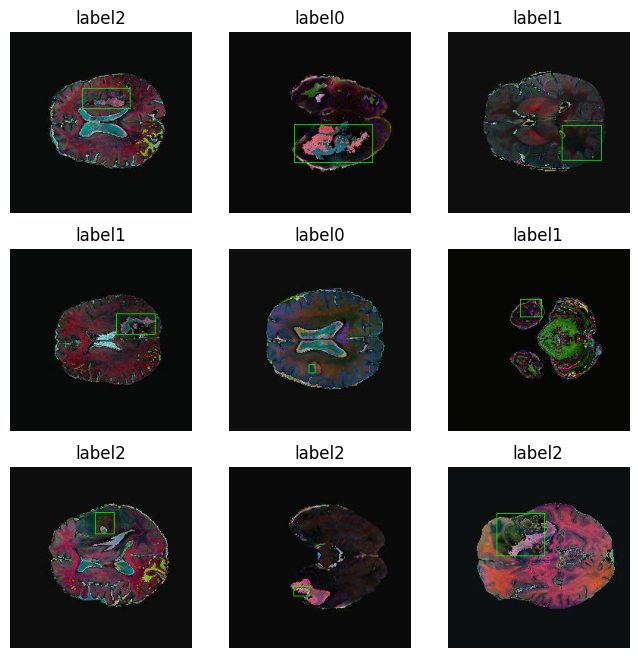

In [20]:
plot_random_images_bbox(image_paths=train_images, 
                        class_ids=train_class_ids, 
                        bboxes=train_bboxes,
                        class_map=class_map)

## Analyzing Imbalance 

In [21]:
(classes, count) = np.unique(train_class_ids, return_counts=True)
classes, count

(array([0, 1, 2], dtype=int8), array([4338, 6836, 4122]))

In [22]:
np.unique(train_class_ids, return_counts=True)[0]

array([0, 1, 2], dtype=int8)

In [23]:
class_labels = np.array([0, 1, 2])
class_counts = np.array([4338, 6836, 4122])

total_samples = sum(class_counts)
class_proportions = class_counts / total_samples

print("Class Proportions:", class_proportions)

Class Proportions: [0.28360356 0.44691423 0.26948222]


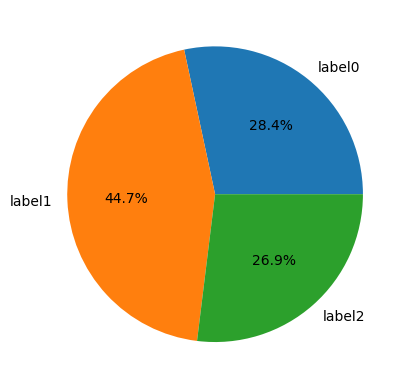

In [24]:
plt.pie(x=count, labels=class_map.values(),autopct='%1.1f%%')
plt.show()

## Rebalance dataset by Down sempling to dataset with min images

In [25]:
del train_images, (train_class_ids, train_bboxes)

In [26]:

rebal_train_images, rebal_train_class_ids, rebal_train_bboxes = prepare_train_dataset.rebalance_by_down_sampling_datasets()
len(rebal_train_images), len(rebal_train_class_ids), len(rebal_train_bboxes)

[INFO] Unique class ids: [0 1 2], value counts: [4338 6836 4122]


(12366, 12366, 12366)

Random samples: [2153, 9558, 9953, 5002, 3557, 8092, 6089, 4284, 6378]


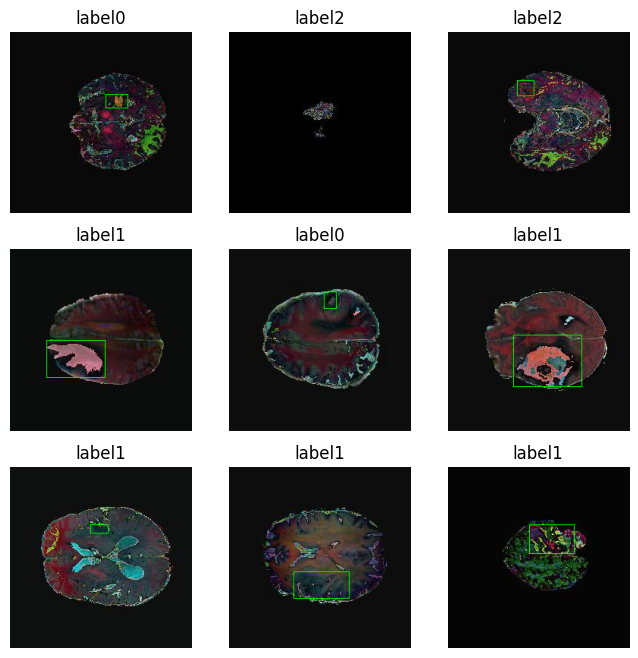

In [27]:
plot_random_images_bbox(image_paths=rebal_train_images,
                        class_ids=rebal_train_class_ids,
                        bboxes=rebal_train_bboxes,
                        class_map=class_map)